In [1]:
import Ab as ab
import datetime as dt



# Get data from yahoo finance
sd = dt.datetime(2001,1,1)
ed = dt.datetime(2023,3,2)
# 1x leveraged nasdaq 100 etf
qqq = ab.StockData('QQQ')
qqq.get_data_from_yfinance('QQQ', sd, ed)
#nasdaq stocks above 200 day moving average percentage

qld = ab.StockData('QLD')
qld.get_data_from_yfinance('QLD', sd, ed)

tqqq= ab.StockData('TQQQ')
tqqq.get_data_from_yfinance('TQQQ', sd, ed)

tqqq_weekly = ab.StockData('TQQQ')
tqqq_weekly.get_data_from_yfinance('TQQQ', sd, ed, '1wk')

naa200r = ab.StockData('NAA200R')
naa200r.get_data_from_csv('data/NAA200R.csv')



GPU acceleration is available
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
import time
def sliding_test(ticker: ab.StockData, indicator:[ab.StockData], stg:ab.Strategy, window: int, inc: int, sd: dt.datetime, ed: dt.datetime, run_strategy: bool = True, verbose: bool = False):
    delta = ed - sd
    result = []
    for i in range(0, delta.days + 1, inc):
        sd_5y = sd + dt.timedelta(days=i)
        ed_5y = sd + dt.timedelta(days=i) + dt.timedelta(days=window)
        t = time.time()
        if run_strategy:
            stg.run_strategy(indicator, sd_5y, ed_5y)
        
        b = time.time()
        bt = None
        bt = ab.BackTest()
        bt.run_backtest(stg, ticker,sd_5y, ed_5y)
        result.append([ed_5y,bt.balance.iloc[-1]['Total']])
        if(verbose):
            print(result[-1], "{:.2}s {:.2}s".format(b-t, time.time() - b))
        
        
        
    return result



In [3]:
test_sd = dt.datetime(2011,3,1)
test_ed = dt.datetime(2018,3,1)
window = 365*5
inc = 21
bts = []
ticker = tqqq
indicator = naa200r

In [5]:
buy_and_hold = ab.BuyAndHold()
bh_result = sliding_test(ticker, ticker, buy_and_hold, window, inc, test_sd, test_ed, True, True)
bts.append([bh_result, buy_and_hold.name])

[datetime.datetime(2016, 2, 28, 0, 0), 4.191876158314093] 0.001s 0.39s
[datetime.datetime(2016, 3, 20, 0, 0), 5.094514861102998] 0.00074s 0.38s
[datetime.datetime(2016, 4, 10, 0, 0), 5.055034903464967] 0.00057s 0.39s
[datetime.datetime(2016, 5, 1, 0, 0), 4.091902627014638] 0.00054s 0.38s
[datetime.datetime(2016, 5, 22, 0, 0), 4.663197182909845] 0.00056s 0.38s
[datetime.datetime(2016, 6, 12, 0, 0), 5.3603389792252605] 0.00063s 0.39s
[datetime.datetime(2016, 7, 3, 0, 0), 4.47479196456686] 0.00062s 0.4s
[datetime.datetime(2016, 7, 24, 0, 0), 4.855027844455583] 0.00061s 0.37s
[datetime.datetime(2016, 8, 14, 0, 0), 7.523351614509505] 0.00058s 0.38s
[datetime.datetime(2016, 9, 4, 0, 0), 7.913496446798397] 0.00075s 0.38s
[datetime.datetime(2016, 9, 25, 0, 0), 7.356381095190712] 0.00057s 0.38s
[datetime.datetime(2016, 10, 16, 0, 0), 6.2787286476673305] 0.00059s 0.4s
[datetime.datetime(2016, 11, 6, 0, 0), 5.533797921928401] 0.00063s 0.39s
[datetime.datetime(2016, 11, 27, 0, 0), 8.09833240295281

/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


[datetime.datetime(2017, 10, 29, 0, 0), 9.982802763270403] 0.00083s 0.38s
[datetime.datetime(2017, 11, 19, 0, 0), 11.164898313811072] 0.00061s 0.41s
[datetime.datetime(2017, 12, 10, 0, 0), 10.22431957521591] 0.00056s 0.38s


/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


[datetime.datetime(2017, 12, 31, 0, 0), 9.803530885390288] 0.00086s 0.4s
[datetime.datetime(2018, 1, 21, 0, 0), 11.910167827451026] 0.00061s 0.37s
[datetime.datetime(2018, 2, 11, 0, 0), 9.44363551380074] 0.00057s 0.38s
[datetime.datetime(2018, 3, 4, 0, 0), 10.858577142975616] 0.00065s 0.39s
[datetime.datetime(2018, 3, 25, 0, 0), 9.31630216038732] 0.00069s 0.38s
[datetime.datetime(2018, 4, 15, 0, 0), 9.3687597682507] 0.00068s 0.39s
[datetime.datetime(2018, 5, 6, 0, 0), 8.808716083614055] 0.00075s 0.41s
[datetime.datetime(2018, 5, 27, 0, 0), 8.981406588679185] 0.00069s 0.42s
[datetime.datetime(2018, 6, 17, 0, 0), 10.341756188237976] 0.00099s 0.42s
[datetime.datetime(2018, 7, 8, 0, 0), 10.209778696550002] 0.00073s 0.4s
[datetime.datetime(2018, 7, 29, 0, 0), 9.530344960239551] 0.0007s 0.39s
[datetime.datetime(2018, 8, 19, 0, 0), 9.828371662407026] 0.00055s 0.4s
[datetime.datetime(2018, 9, 9, 0, 0), 9.095329519424363] 0.00072s 0.41s
[datetime.datetime(2018, 9, 30, 0, 0), 9.200129154572814] 

In [ ]:
naa200r_40_stg = ab.Threshold('NAA200R', buy_threshold = 15, sell_threshold = 30, signal_ma_window = 40)
naa200r_40_stg_result = sliding_test(ticker, indicator, naa200r_40_stg, window, inc, test_sd,test_ed, True)
bts.append([naa200r_40_stg_result, naa200r_40_stg.name])



AttributeError: 'list' object has no attribute 'data'

In [ ]:
naa200r_20_stg = ab.Threshold('NAA200R', buy_threshold = 15, sell_threshold = 30)
naa200r_20_stg_result = sliding_test(ticker, indicator, naa200r_20_stg,window, inc, test_sd,test_ed, True)
bts.append([naa200r_20_stg_result, naa200r_20_stg.name])

In [ ]:
ma_threshold = ab.MAThreshold(ma_window = 200, buy_threshold = 1.00, sell_threshold = 1)
ma_threshold_result = sliding_test(ticker,indicator, ma_threshold,window, inc, test_sd,test_ed, True)
bts.append([ma_threshold_result, ma_threshold.name])


In [ ]:
ma_threshold2 = ab.MAThreshold(ma_window = 200, buy_threshold = 1.03, sell_threshold = 0.95)
ma_threshold_result2 = sliding_test(ticker, indicator, ma_threshold2,window, inc, test_sd,test_ed, True)
bts.append([ma_threshold_result2, ma_threshold2.name])


In [ ]:
macross_strategy = ab.MACross(short_window=50, long_window=200)
ma_threshold_result2 = sliding_test(ticker, indicator, macross_strategy,window, inc, test_sd,test_ed, True)
bts.append([ma_threshold_result2, macross_strategy.name])

In [ ]:
stochastic_strategy = ab.StochasticCross(k_window=14, full_k_window=5, full_d_window=5, overbought=80, oversold=10)
stochastic_strategy_result = sliding_test(ticker, [tqqq, tqqq_weekly], stochastic_strategy,window, inc, test_sd,test_ed, True, True)
bts.append([stochastic_strategy_result, stochastic_strategy.name])

[datetime.datetime(2016, 2, 28, 0, 0), 6.75075346050107] 0.0092s 0.46s
[datetime.datetime(2016, 3, 20, 0, 0), 8.224952892476683] 0.0064s 0.45s
[datetime.datetime(2016, 4, 10, 0, 0), 8.575668051561712] 0.0067s 0.46s
[datetime.datetime(2016, 5, 1, 0, 0), 7.4781819187693515] 0.0073s 0.44s
[datetime.datetime(2016, 5, 22, 0, 0), 8.448751195385803] 0.006s 0.46s
[datetime.datetime(2016, 6, 12, 0, 0), 9.07505370700972] 0.0065s 0.44s
[datetime.datetime(2016, 7, 3, 0, 0), 8.842221021436355] 0.0067s 0.45s
[datetime.datetime(2016, 7, 24, 0, 0), 9.216855340001944] 0.0066s 0.45s
[datetime.datetime(2016, 8, 14, 0, 0), 11.121108826944491] 0.0064s 0.45s
[datetime.datetime(2016, 9, 4, 0, 0), 11.071803888843059] 0.0064s 0.44s
[datetime.datetime(2016, 9, 25, 0, 0), 11.81679940263416] 0.0065s 0.48s
[datetime.datetime(2016, 10, 16, 0, 0), 10.273156586633382] 0.0062s 0.45s
[datetime.datetime(2016, 11, 6, 0, 0), 10.56618562293991] 0.0067s 0.44s
[datetime.datetime(2016, 11, 27, 0, 0), 14.57352787982444] 0.0069

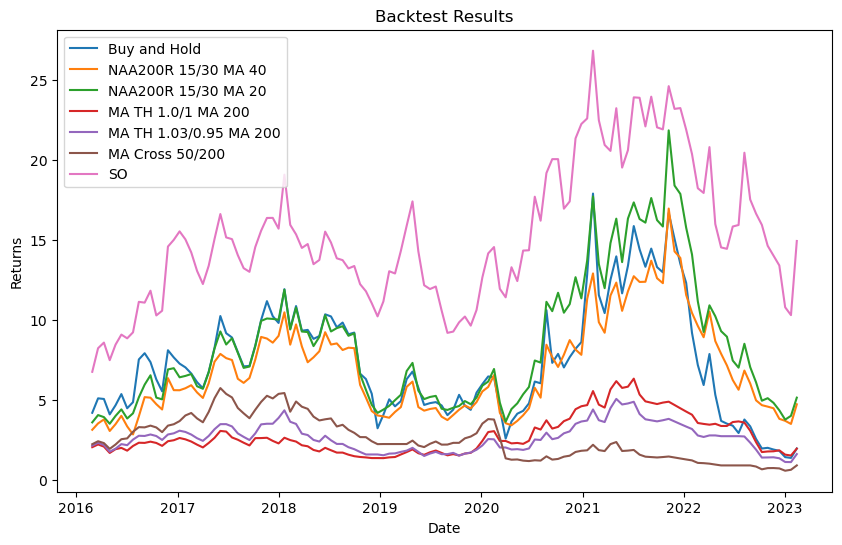

In [ ]:
import matplotlib.pyplot as plt

def plot_bt(backtests):
    fig, ax = plt.subplots(figsize=(10, 6))

    for bt in backtests:
        dates = [x[0] for x in bt[0]]
        returns = [x[1] for x in bt[0]]
        label = bt[1]

        ax.plot(dates, returns, label=label)

    ax.legend(loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.set_title('Backtest Results')

    plt.show()
plot_bt(bts)

In [ ]:
import numpy as np
#calculat the avg and std of the results
def calc_avg_std(bt):
    returns = [x[1] for x in bt]
    return np.mean(returns), np.std(returns)

for bt in bts:
    avg, std = calc_avg_std(bt[0])
    print(f'{bt[1]}: avg: {avg}, std: {std}')



Buy and Hold: avg: 7.36359607647038, std: 3.55438841367916
NAA200R 15/30 MA 40: avg: 6.944025859912387, std: 2.9725140979373648
NAA200R 15/30 MA 20: avg: 8.389872538640159, std: 4.054624878044215
MA TH 1.0/1 MA 200: avg: 2.7674566589536096, std: 1.2128595100679704
MA TH 1.03/0.95 MA 200: avg: 2.64249317124311, std: 0.8723058302494827
MA Cross 50/200: avg: 2.5111276453593527, std: 1.323316785331854
